# Convolutional neural net with pytorch (and pytorch lightning ⚡)

![](cnn.png)

* Today we will code a convolutional neural networks (CNNs), a type of neural network which is specifically well suited for dealing with images. In the previous tutorial we have seen that multilayer perceptrons present strong limitations when dealing with high dimensional inputs and in this tutorial we will see how CNNs are able to overcome these limitations

* We will be training a CNN on the FashionMNIST dataset

* We will use pytorch and pytorch-lightning and show some tools, such as the tensorboard

## Libraries and notebook methods

In [56]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import pdb
import pytorch_lightning as pl

# Import matplotlib and numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

from sklearn.metrics import (classification_report, roc_curve, 
                             precision_recall_curve, roc_auc_score, average_precision_score)
from IPython.display import Image

In [2]:
# Check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu111
0.9.0+cu111


In [3]:
workers = multiprocessing.cpu_count()

# Simple validation in case we have a GPU available
gpu = -1 if torch.cuda.is_available() else 0

num_epochs = 20

### Image display

In [4]:
def show_images(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

### Model performance metrics

In [5]:
cnn_arch_df = pd.DataFrame(columns=[
    'class', 
    'name', 
    'params', 
    #'auc', 
    'precision', 
    'recall', 
    'f1',
    'y_hat'
])

In [6]:
def get_predictions(model, loader):
    model.eval()
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        imgs, _ = batch
        preds = model(imgs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    scores = F.softmax(all_preds, dim=1)
    
    return scores.argmax(dim=1)

def model_performance(model, loader, display=True):
    y_h = get_predictions(model, loader)
    msg = "Classification report for {}".format(type(model).__name__)
    #print(data.targets, y_h)
    y = loader.dataset.targets
    if display:
        print(msg)
        print("-" * len(msg))
        print(classification_report(y, y_h))
        skplt.metrics.plot_confusion_matrix(y, y_h, normalize=True, figsize=(10, 10))
        return
    return classification_report(y, y_h, output_dict=True)


## Dataset loading

In [8]:
# Use standard FashionMNIST dataset

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

image_datasets = {
    'train': torchvision.datasets.FashionMNIST(
        root = './data/FashionMNIST',
        train = True,
        download = True, 
        transform = data_transforms['train']),
    
    'val': torchvision.datasets.FashionMNIST(
        root = './data/FashionMNIST',
        train = False,
        download = True, 
        transform = data_transforms['val'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=workers),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=512, shuffle=False, num_workers=workers)
}

class_names = image_datasets['train'].classes

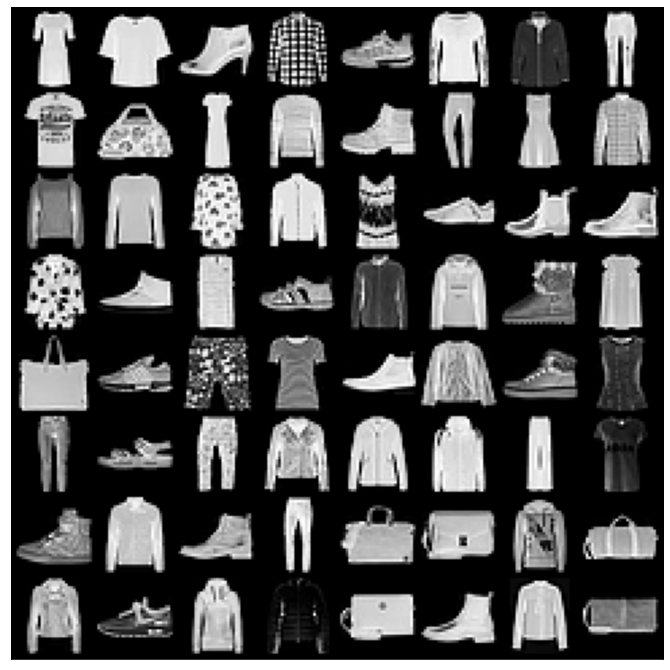

In [9]:
train_iter = iter(dataloaders['train'])
images, labels = next(train_iter)
show_images(torchvision.utils.make_grid(images))

In [10]:
np.set_printoptions(linewidth=120)
np.array([class_names[labels[j].item()] for j in range(64)]).reshape(8, 8)

array([['Dress', 'Shirt', 'Ankle boot', 'Shirt', 'Sneaker', 'Pullover', 'Coat', 'Trouser'],
       ['T-shirt/top', 'Bag', 'Dress', 'Pullover', 'Ankle boot', 'Trouser', 'Dress', 'Shirt'],
       ['Pullover', 'Pullover', 'Dress', 'Coat', 'T-shirt/top', 'Sneaker', 'Ankle boot', 'Ankle boot'],
       ['Coat', 'Sneaker', 'T-shirt/top', 'Sandal', 'Shirt', 'Coat', 'Ankle boot', 'Dress'],
       ['Bag', 'Sneaker', 'Trouser', 'T-shirt/top', 'Ankle boot', 'Coat', 'Ankle boot', 'Shirt'],
       ['Trouser', 'Sandal', 'Trouser', 'Coat', 'Coat', 'Coat', 'Trouser', 'T-shirt/top'],
       ['Sneaker', 'Coat', 'Ankle boot', 'Trouser', 'Bag', 'Bag', 'Pullover', 'Bag'],
       ['Coat', 'Sneaker', 'Pullover', 'Coat', 'Bag', 'Ankle boot', 'Shirt', 'Bag']], dtype='<U11')

## A CNN architecture using pytorch-lightning

Since we will use pytorch-lightning, our class needs to inherit from pl.LightningModule

### Architecture

In [69]:
class FashionCNN(pl.LightningModule):
    
    def __init__(self, model_name):
        super(FashionCNN, self).__init__()
        
        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=2304, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
        self.accuracy = pl.metrics.Accuracy()
        
        self.name = model_name
    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        # import pdb; pdb.set_trace()
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        self.train()
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self.eval()
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)

In [70]:
net = FashionCNN("Net1")

### Training check

In [13]:
print(net)

FashionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (accuracy): Accuracy()
)


In [14]:
# Initialize a trainer
trainer = pl.Trainer(gpus=gpu, progress_bar_refresh_rate=20, fast_dev_run=True)
trainer.fit(net, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

## Tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
# get some random training images
dataiter = iter(fmnist_train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
#matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('64_fashion_mnist_images', img_grid)

In [ ]:
writer.add_graph(net, images)
writer.close()

In [ ]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(fmnist_train.data, fmnist_train.targets)

# get the class labels for each image
class_labels = [class_mapping[lab.item()] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [ ]:
#%tensorboard --logdir=runs/

In [ ]:
%tensorboard --logdir=lightning_logs4a/

## Training and Validation

In [15]:
trainer = pl.Trainer(gpus=gpu, max_epochs=num_epochs, progress_bar_refresh_rate=20, default_root_dir="lightning_logs4a")
trainer.fit(net, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 320   
1 | conv_block2 | Sequential | 18.5 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

## Validation metrics

Classification report for FashionCNN
------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.83      0.78      1000
           1       0.97      0.96      0.97      1000
           2       0.63      0.78      0.69      1000
           3       0.83      0.80      0.82      1000
           4       0.62      0.64      0.63      1000
           5       0.95      0.92      0.94      1000
           6       0.56      0.34      0.43      1000
           7       0.90      0.92      0.91      1000
           8       0.90      0.94      0.92      1000
           9       0.93      0.92      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.80      0.81      0.80     10000
weighted avg       0.80      0.81      0.80     10000



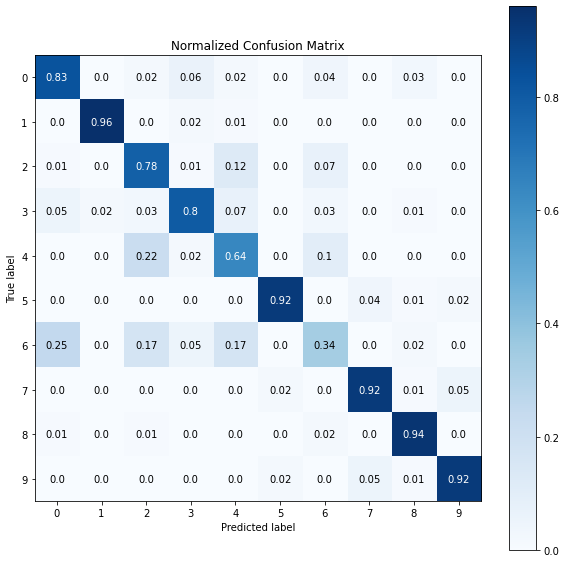

In [18]:
model_performance(net, dataloaders['val'])

## Your turn ! Here are some things to do

For this homework, do the following:

- Add data augmentation in the transformations used in the DataLoaders (have a look at https://github.com/zalandoresearch/fashion-mnist)
- Look for a better architecture (for instance, change padding and kernel sizes, have a look at https://github.com/zalandoresearch/fashion-mnist), try different solvers / learning rates
- Remove batch normalization, change dropout parameters, try residual connections
- It's possible to reach > 94% accuracy, once again have a look at https://github.com/zalandoresearch/fashion-mnist

### Data Augmentation

In [71]:
transformers = transforms.Compose([ 
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.5,],[0.5,])
])

In [72]:
# We just make data augmentation for the training dataset
train_t = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transformers
)

augmented_loader = DataLoader(train_t, batch_size=64, num_workers=workers, shuffle=True)

In [73]:
train_t

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


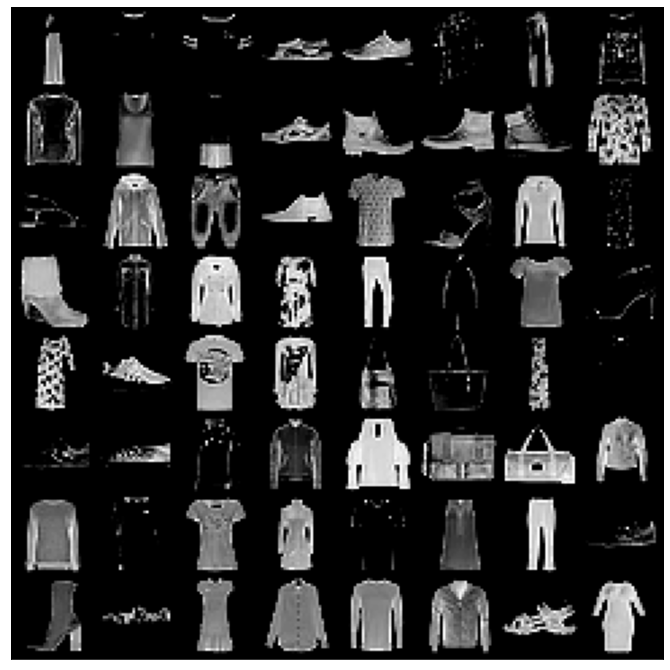

In [74]:
train_t_iter = iter(augmented_loader)
images_t, labels_t = next(train_t_iter)
show_images(torchvision.utils.make_grid(images_t))

In [76]:
net_aug = FashionCNN("Augmented")
print(net_aug)

FashionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (accuracy): Accuracy()
)


In [77]:
trainer_aug = pl.Trainer(gpus=gpu, max_epochs=num_epochs, progress_bar_refresh_rate=20, default_root_dir="lightning_logs4a")
trainer_aug.fit(net_aug, train_dataloader=augmented_loader, val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 384   
1 | conv_block2 | Sequential | 18.6 K
2 | fc1         | Linear     | 1.4 M 
3 | drop        | Dropout2d  | 0     
4 | fc2         | Linear     | 72.1 K
5 | fc3         | Linear     | 1.2 K 
6 | accuracy    | Accuracy   | 0     
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.901     Total estimated model params size (MB)


1

### New Architecture

In [46]:
class FashionCNN2(pl.LightningModule):
    
    def __init__(self, model_name):
        super(FashionCNN2, self).__init__()
        
        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        
#         # Third convolutional block
#         self.conv_block3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
#             nn.ReLU(),
#            # nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2)
#         #
#         )
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=1600,out_features=400),
            nn.ReLU()
        )
     #   self.drop = nn.Dropout2d(0.2) # Maybe change to .5
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=400, out_features=100),
            nn.ReLU()
        )
      #  self.drop2 = nn.Dropout2d(0.3)
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=10)
        )
        
        self.accuracy = pl.metrics.Accuracy()
        self.name = model_name
        
    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
       # out = self.conv_block3(out)
      #  out = self.conv_block4(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        #import pdb; pdb.set_trace()
       # print(x.shape)
        out = self.fc1(x)
      #  out = self.drop(out)
        out = self.fc2(out)
        #Wout = self.drop2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        self.train()
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self.eval()
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-3)

In [66]:
new_net = FashionCNN2("NewNet")

#### Training check

In [63]:
#trainer = pl.Trainer(gpus=gpu, progress_bar_refresh_rate=20, fast_dev_run=True)
#trainer.fit(new_net, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

#### Training and validation loop

In [67]:
trainer = pl.Trainer(gpus=gpu, max_epochs=num_epochs, progress_bar_refresh_rate=20, default_root_dir="lightning_logs4a")
trainer.fit(new_net, train_dataloader=dataloaders['train'], val_dataloaders=dataloaders['val'])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type       | Params
-------------------------------------------
0 | conv_block1 | Sequential | 896   
1 | conv_block2 | Sequential | 18.6 K
2 | fc1         | Sequential | 640 K 
3 | fc2         | Sequential | 40.1 K
4 | fc3         | Sequential | 1.0 K 
5 | accuracy    | Accuracy   | 0     
-------------------------------------------
701 K     Trainable params
0         Non-trainable params
701 K     Total params
2.804     Total estimated model params size (MB)


1

### Overall validation accuracy and train loss for different architectures

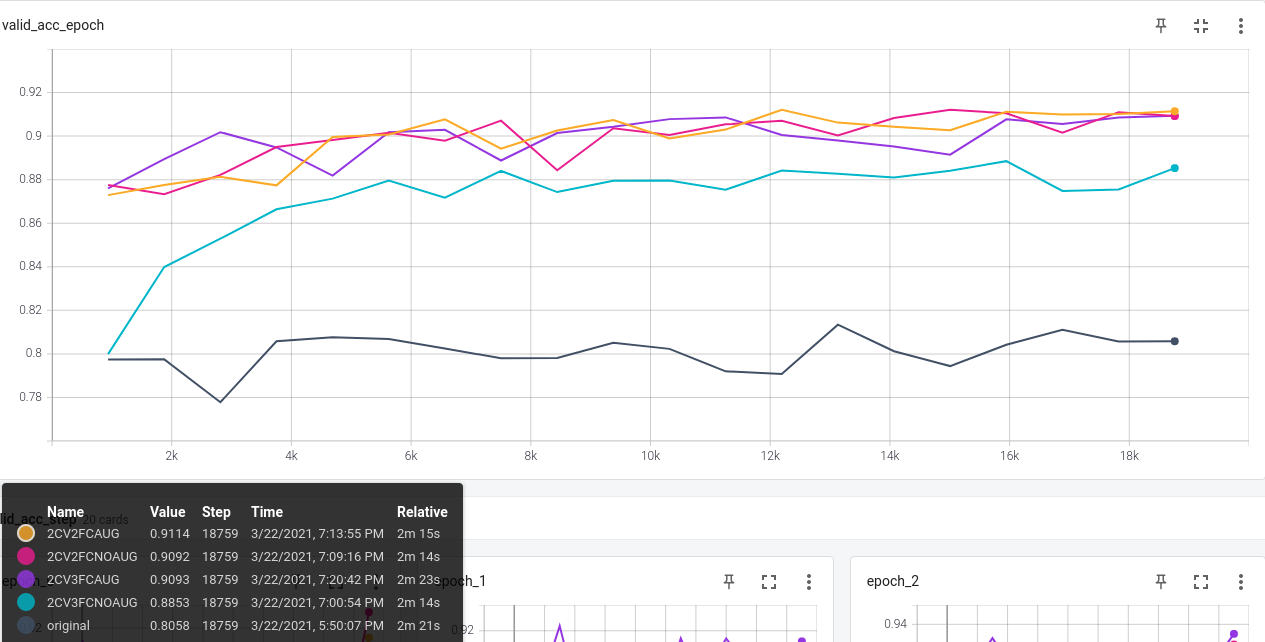

In [51]:
Image(filename='Validationaccuracy.png') 

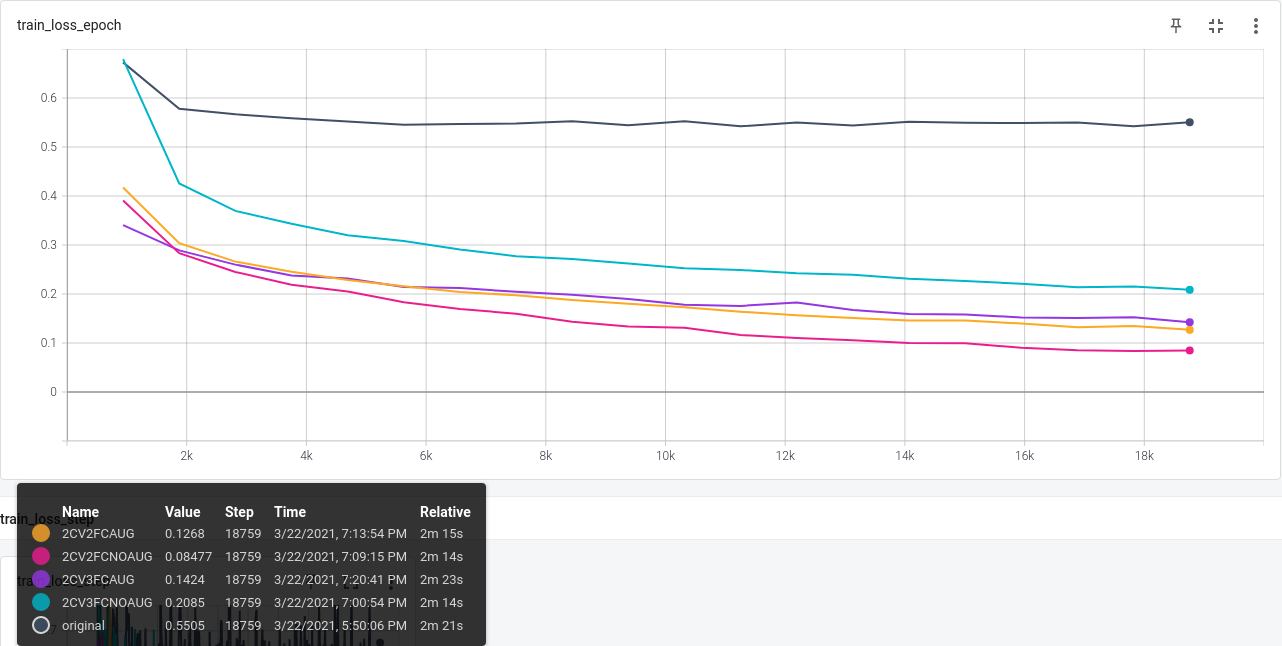

In [55]:
Image(filename='Trainloss.png') 

# After testing approximately 30-40 networks we have noticed some things. Firstly, data augmentation does work but does not increase the accuracy by that much. For a Neural Network with 2 Conv layers and 2 FC layers the accuracy increased by 0.2%. Also, the networks that worked best for us are the ones that were not that complicated, by making a network more complicated the accuracy generally diminished. In the end we had some overfitting networks, and for them we used Maxpooling and other regularization techniques. In the end we got to an accuracy of slightly more than 91%.

### Best performing network

Classification report for FashionCNN2
-------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.87      0.87      1000
           3       0.93      0.90      0.91      1000
           4       0.82      0.87      0.85      1000
           5       0.97      0.99      0.98      1000
           6       0.77      0.70      0.73      1000
           7       0.96      0.95      0.96      1000
           8       0.96      0.99      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



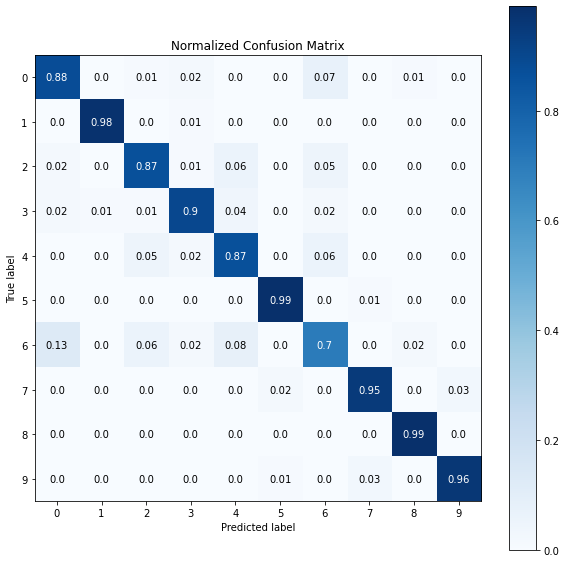

In [54]:
model_performance(new_net, dataloaders['val'])